# Predicting Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

In this project, we'll try to predict the total number of bikes people rented in a given hour. We will use the data set provided by UC Irvine, which is available [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

Here are the descriptions for the relevant columns:

- **instant** - A unique sequential ID number for each row
- **dteday** - The date of the rentals
- **season** - The season in which the rentals occurred
- **yr** - The year the rentals occurred
- **mnth** - The month the rentals occurred
- **hr** - The hour the rentals occurred
- **holiday** - Whether or not the day was a holiday
- **weekday** - The day of the week (as a number, 0 to 7)
- **workingday** - Whether or not the day was a working day
- **weathersit** - The weather (as a categorical variable)
- **temp** - The temperature, on a 0-1 scale
- **atemp** - The adjusted temperature
- **hum** - The humidity, on a 0-1 scale
- **windspeed** - The wind speed, on a 0-1 scale
- **casual** - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- **registered** - The number of registered riders (people who had already signed up)
- **cnt** - The total number of bike rentals (casual + registered)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


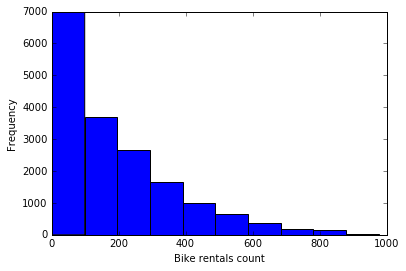

In [9]:
bike_rentals['cnt'].plot.hist()
plt.xlabel('Bike rentals count')

## Calculating features

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

In [10]:
bike_rentals.corr().sort_values(by='cnt')['cnt']

time_label   -0.378318
hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [11]:
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3

bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

#### Error metric

The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

In [15]:
from sklearn.metrics import mean_squared_error

train = bike_rentals.sample(frac=.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Applying linear regression

Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with **cnt**.

In [16]:
from sklearn.linear_model import LinearRegression

predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")

reg = LinearRegression()
reg.fit(train[predictors], train["cnt"])
predictions = reg.predict(test[predictors])
mean_squared_error(test['cnt'], predictions)

17581.34433302975

The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

## Applying decision trees

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [18]:
from sklearn.tree import DecisionTreeRegressor

leaf_sizes = [2, 5, 8]
means = []
for leaf in leaf_sizes:
    reg = DecisionTreeRegressor(min_samples_leaf=5)
    reg.fit(train[predictors], train["cnt"])
    predictions = reg.predict(test[predictors])
    means.append(mean_squared_error(test['cnt'], predictions))
    
print(means)

[2460.4687129681365, 2475.62304963764, 2439.246333055894]


We see the leaf size having a minimal impact on the MSE.Overall,  by taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

## Applying random forests

Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [19]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(min_samples_leaf=5)
reg.fit(train[predictors], train["cnt"])
predictions = reg.predict(test[predictors])
mean_squared_error(test['cnt'], predictions)

1858.5077812897723

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.

## Next steps...

Here are some potential next steps:

- Calculate additional features, such as:
    - An index combining temperature, humidity, and wind speed
- Try predicting casual and registered instead of cnt.